In [1]:
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset
from torchvision import transforms
from tqdm import tqdm
import cv2
# %run ConV_VAE.ipynb
# %run bigger_latent_space.ipynb
%run rgb200x200.ipynb
%run loader.ipynb
%run test.ipynb
%run train.ipynb

In [2]:
plt.rcParams['figure.dpi'] = 75
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
####### IMPORTANT ######
# set this flag to true if you want to load the model beforehand
load = False
# specify which model you want to load
model_name = None
img_size = 100
batch_size = 16
in_channels = 1
classes = 26

cuda


In [3]:
normalize = transforms.Lambda(lambda x: x / 255.0)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(img_size),
    normalize
])
train_data = CustomImageDataset('../data/sign_mnist_train.csv', transform=transform)
test_data = CustomImageDataset('../data/sign_mnist_test.csv', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [4]:
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
for batch in train_loader:
    input, labels = batch
    print(input.shape)
    break

torch.Size([16, 1, 100, 100])


C:\Users\radug\miniconda3\envs\cv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
import numpy as np

model = cVAE((in_channels, img_size, img_size), classes).to(device)
# model = ConvVarAutoencoder()
BCE_loss = torch.nn.BCELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0001)
img = np.zeros((img_size,img_size))
img[img_size//2,img_size//2] = 1
weights = torch.tensor(cv2.GaussianBlur(img, (img_size-3,img_size-3), 0)).to(device)
def loss(X, X_hat, mean, logvar):
    X = X #* weights
    X_hat = X_hat #* weights
    reconstruction_loss = BCE_loss(X_hat, X)
    KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean ** 2)
    return reconstruction_loss + KL_divergence

In [6]:
import time

lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=0.0001)
early_stop = EarlyStop(patience=5, save_name="100x100_conv_no_SSR_50.pt")


def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate


max_epochs = 50
net = model.to(device)
if load:
    checkpoint = torch.load("model.pt", map_location=device)
    net.load_state_dict(checkpoint["net"])
    net.to(device)
    print("model loaded")
train_losses = []
print("training on ", device)
for epoch in range(max_epochs):

    train_loss, n, start = 0.0, 0, time.time()
    for X, y in tqdm(train_loader, ncols=50):
        X = X.to(device)
        y = y.to(device)
        X_hat, mean, logvar = net(X, y)
        X_hat  = net(X)
        l = loss(X, X_hat, mean, logvar).to(device)
        # l = loss(X, X_hat).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    train_losses.append(train_loss)
    print('epoch %d, train loss %.4f , time %.1f sec'
          % (epoch, train_loss, time.time() - start))

    adjust_lr(optimizer)

    if (early_stop(train_loss, net, optimizer)):
        break

training on  cuda


  0%|                    | 0/1716 [00:07<?, ?it/s]


TypeError: loss() missing 2 required positional arguments: 'mean' and 'logvar'

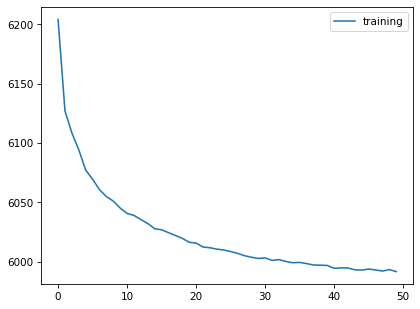

In [15]:
plt.plot(train_losses, label="training")
plt.legend()
plt.show()

In [32]:
from matplotlib import cm

checkpoint = torch.load("100x100_rgb_capable_50epochs.pt", map_location=device)
net = cVAE((in_channels, img_size, img_size), classes).to(device)
net.load_state_dict(checkpoint["net"])
net.to(device)
net.eval()

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

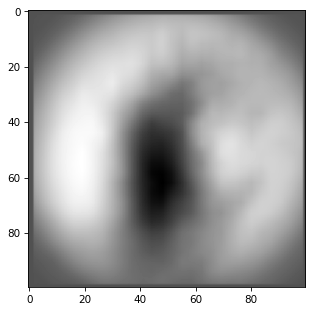

In [36]:
number = 5
with torch.no_grad():
    x = net.generate(number)
x = x.transpose(0, 2).transpose(0, 1)
x = x.squeeze(2).cpu().numpy()
plt.imshow(x, cm.gray)
# x = x * 255
#cv2.imwrite(str(number) + '.png', x)

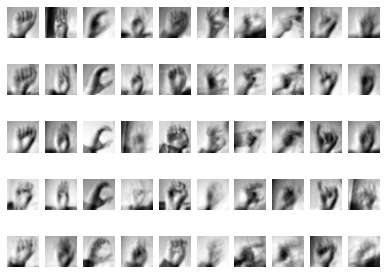

In [24]:
with torch.no_grad():
    x = net.generate(torch.tensor([list(range(10))] * 5).clone().view(-1))
for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.axis("off")
    img = x[i].transpose(0, 2).transpose(0, 1)
    plt.imshow(img.squeeze(0).cpu().numpy(), cm.gray)